In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional
import matplotlib

sns.set_context("notebook", font_scale=1)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Nimbus Sans'

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

from IPython.display import display

def restore_minor_ticks_log_plot(
    ax: Optional[plt.Axes] = None, n_subticks=9
) -> None:
    """For axes with a logrithmic scale where the span (max-min) exceeds
    10 orders of magnitude, matplotlib will not set logarithmic minor ticks.
    If you don't like this, call this function to restore minor ticks.

    Args:
        ax:
        n_subticks: Number of Should be either 4 or 9.

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()
    # Method from SO user importanceofbeingernest at
    # https://stackoverflow.com/a/44079725/5972175
    locmaj = mpl.ticker.LogLocator(base=10, numticks=1000)
    ax.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(
        base=10.0, subs=np.linspace(0, 1.0, n_subticks + 2)[1:-1], numticks=1000
    )
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_major_locator(locmaj)    
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

In [2]:
with open("../methods/data/mm9.chromFa.tar.gz.3mer.counts") as iH:    
    for line in iH:                
        if line.strip().startswith("CAC"):
            mm9_genome_CACs = int(next(iH).strip()[1:])
            print("mm9.genome", "{:,}".format(mm9_genome_CACs))        
mm9_CAn_CACs = pd.concat([pd.read_csv("../methods/data/mm9.CAn.nuc", sep="\t"),
    pd.read_csv("../methods/data/mm9.CAn.GTG.nuc", sep="\t")])["13_user_patt_count"].sum()
print("mm9.CAn.bed  {:,}".format(mm9_CAn_CACs))

print("")
with open("../methods/data/mm10.fa.gz.3mer.counts") as iH:    
    for line in iH:                
        if line.strip().startswith("CAC"):
            mm10_genome_CACs = int(next(iH).strip()[1:])
            print("mm10.genome", "{:,}".format(mm10_genome_CACs))        
mm10_CAn_CACs = pd.concat([pd.read_csv("../methods/data/mm10.CAn.nuc", sep="\t"),
    pd.read_csv("../methods/data/mm10.CAn.GTG.nuc", sep="\t")])["13_user_patt_count"].sum()
print("mm10.CAn.bed  {:,}".format(mm10_CAn_CACs))

print("")
with open("../methods/data/chm13.draft_v1.1.fasta.gz.3mer.counts") as iH:    
    for line in iH:                
        if line.strip().startswith("CAC"):
            chm13_genome_CACs = int(next(iH).strip()[1:])
            print("chm13.genome", "{:,}".format(chm13_genome_CACs))        
chm13_CAn_CACs = pd.concat([pd.read_csv("../methods/data/chm13.CAn.nuc", sep="\t"),
    pd.read_csv("../methods/data/chm13.CAn.GTG.nuc", sep="\t")])["13_user_patt_count"].sum()
print("chm13.CAn.bed    {:,}".format(chm13_CAn_CACs))

mm9.genome 109,196,385
mm9.CAn.bed  6,987,442

mm10.genome 110,367,609
mm10.CAn.bed  6,490,524

chm13.genome 120,794,608
chm13.CAn.bed    949,940


In [3]:
# Fraction of CACs in CA repeats (mouse mm9)
mm9_CAn_CACs / mm9_genome_CACs

0.06398968244232628

In [4]:
# Fraction of CACs in CA repeats (mouse mm10)
mm10_CAn_CACs / mm10_genome_CACs

0.05880823240449107

In [5]:
# Fraction of CACs in CA repeats (human chm13)
chm13_CAn_CACs / chm13_genome_CACs

0.007864092741623037

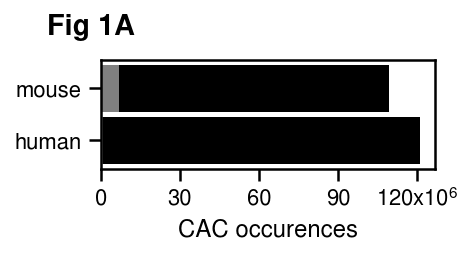

In [6]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1d' % (x * 1e-6)
labels = ["human", "mouse"]
genome_CACs = [chm13_genome_CACs-chm13_CAn_CACs, mm9_genome_CACs-mm9_CAn_CACs]
CAn_CACs = [chm13_CAn_CACs, mm9_CAn_CACs]
width=0.9

fig, ax = plt.subplots(figsize=(3, 1))

formatter = FuncFormatter(millions)

ax.barh(labels, CAn_CACs, width, label="[CA]n", color="grey")
ax.barh(labels, genome_CACs, width, left=CAn_CACs, label="genome", color="black")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks([i*1e6 for i in [0, 30, 60, 90, 120]])
ax.set_xlabel("CAC occurences")
ax.text(0.0, 1.2, "Fig 1A", transform=fig.transFigure, va='top', weight="bold", fontsize="x-large")
_ = ax.set_xticklabels(["0", "30", "60", "90", r"120x$\mathregular{10^6}$"])
fig.savefig("pdfs/fig1a.pdf")

In [7]:
def get_mCAC_mCA_CAn(x, y, bins=100):
    x_df = pd.read_csv(x, sep="\t", header=None, index_col=3, low_memory=False)[[6]].replace(".", np.nan).astype(float).dropna()    
    y_df = pd.read_csv(y, sep="\t", header=None, index_col=3, low_memory=False)[[6]].replace(".", np.nan).astype(float).dropna()
    df = pd.concat([x_df, y_df], axis=1).dropna()
    df.columns = ["mCAC", "mCA CAn"]
    df["mCAC bins"] = pd.qcut(df["mCAC"], bins, duplicates="drop")
    return df

def mean_std_err(df, groupby="mCAC bins"):
    mean = df.groupby(groupby).mean()
    std = df.groupby(groupby).sem()
    return mean, std

def plot(ax, l2fc, log=True, groupby="mCAC bins", ylabel=True):
    mean, std = mean_std_err(l2fc, groupby=groupby)
    r = l2fc[[groupby.split(" bins")[0], "mCA CAn"]].dropna().corr(method="pearson").values[0][1]
    # ax.scatter(l2fc["mCAC"].values, l2fc["mCA CAn"].values, color="black", s=8, edgecolor="white", linewidth=0.5)
    ax.errorbar(x=mean[groupby.split(" bins")[0]].values,
                y=mean["mCA CAn"].values,
                xerr=std[groupby.split(" bins")[0]].values,
                yerr=std["mCA CAn"].values,
                fmt="o", color="black", markersize=4, alpha=0.25)    
    ax.set_xlabel("")
    ax.axhline(y=0, color="black", linestyle="dashed", linewidth=1)
    ax.text(0.05, 0.95, r"$\mathregular{R^2}=$"+"{:.2f}".format(r*r), transform=ax.transAxes, va='top')
    ax.text(0.4, 0.15, "n={:,}".format(len(l2fc)), transform=ax.transAxes, va='top')
    if ylabel:    
        ax.set_ylabel(r"mCA [CA]n")
    ax.set_xlabel("mCAC")
    
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
        restore_minor_ticks_log_plot(ax)    

# Fig 1B

In [8]:
rows = [[],[],[]]
for gse, name, cov, n in zip(["GSE47966", "GSE84533", "GSE128172"],
    ["GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos", "GSE84533_hypothalamus_rep123", "GSE128172_MeCP2_WT_OX_rep123"],
    [10, 5, 5], [0,1,2]):    
    for context, subcontext in zip(["CAC", "CAC", "CA", "CA", "CA", "CG"], ["CAC", "subtract.CAn", "CAn", "CANn", "CA", "CG"]):
        if context == subcontext:
            file = f"../wgbs/{gse}/{name}.{context}.{cov}.mC.txt"
        else:
            file = f"../wgbs/{gse}/{name}.{context}.{cov}.{subcontext}.mC.txt"
        rows[n].append(float(open(file).read().strip()))
df = pd.DataFrame(rows).T
df.index = ["CAC", "CAC except [CA]n", "CAn", "CANn", "CA", "CG"]
df.columns = ["FC NeuN+ve", "HY NeuN+ve", "FB whole"]
df.style.format('{:,.2%}'.format)

,FC NeuN+ve,HY NeuN+ve,FB whole
CAC,11.63%,7.06%,4.87%
CAC except [CA]n,11.60%,6.96%,4.90%
CAn,10.58%,8.40%,4.11%
CANn,1.36%,1.45%,1.37%
CA,4.85%,3.10%,2.17%
CG,85.44%,77.66%,65.07%


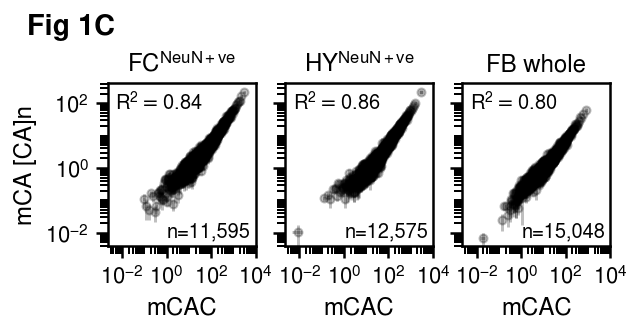

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(4.5, 1.5), sharex=True, sharey=True)

for file, ax, ylabel, name in zip(["GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos", "GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123",
    "GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123"], axes, [True, False, False],
    [r"$\mathregular{FC^{NeuN+ve}}$", r"$\mathregular{HY^{NeuN+ve}}$", "FB whole"]):
    x = f"../rnaseq/methylation/{file}.CAC.sum.tsv"
    y = f"../rnaseq/methylation/{file}.CAn.sum.tsv"
    df = get_mCAC_mCA_CAn(x, y, bins=1000)
    plot(ax, df, ylabel=ylabel)
    ax.set_title(name)
    ax.set_xticks([0.01, 1, 100, 10000])
    ax.set_yticks([0.01, 1, 100])
_ = axes[0].text(0.0, 1.2, "Fig 1C", transform=fig.transFigure, va='top', weight="bold", fontsize="x-large")
fig.savefig("pdfs/fig1c.pdf")

In [10]:
import gzip
def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b

def count_lines(file):
    with gzip.open(file, "r") as f:
        return sum(bl.count(b"\n") for bl in blocks(f))
    
rows = [[],[],[],[],[]]
for gse, name, cov, n in zip(["GSE47966", "GSE47966", "GSE47966",  "GSE84533", "GSE128172"],
    ["GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos", "GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_neg",
     "GSE47966_MethylC-Seq_mm_fc_6wk", "GSE84533_hypothalamus_rep123", "GSE128172_MeCP2_WT_OX_rep123"],
    [10, 10, 10, 5, 5], [0,1,2,3,4]):    
    for context, subcontext in zip(["CAC", "CAC"], ["subtract.CAn", "CAn"]):
        if context == subcontext:
            file = f"../wgbs/{gse}/{name}.{context}.{cov}.bedGraph.gz"
        else:
            file = f"../wgbs/{gse}/{name}.{context}.{cov}.{subcontext}.bedGraph.gz"
        rows[n].append(count_lines(file))
df = pd.DataFrame(rows).T
df.index = ["CAC", "CAn"]
df.columns = ["FC NeuN+ve", "FC NeuN-ve", "FC whole", "HY NeuN+ve", "FB whole"]

In [11]:
df.loc["CAC", ["FC NeuN+ve", "FC NeuN-ve", "FC whole", "HY NeuN+ve"]] = df.loc["CAC", ["FC NeuN+ve", "FC NeuN-ve", "FC whole", "HY NeuN+ve"]] / (mm9_genome_CACs-mm9_CAn_CACs)
df.loc["CAn", ["FC NeuN+ve", "FC NeuN-ve", "FC whole", "HY NeuN+ve"]] = df.loc["CAn", ["FC NeuN+ve", "FC NeuN-ve", "FC whole", "HY NeuN+ve"]] / mm9_CAn_CACs
df.loc["CAC", ["FB whole"]] = df.loc["CAC", ["FB whole"]] / (mm10_genome_CACs-mm10_CAn_CACs)
df.loc["CAn", ["FB whole"]] = df.loc["CAn", ["FB whole"]] / mm10_CAn_CACs
df = df.T

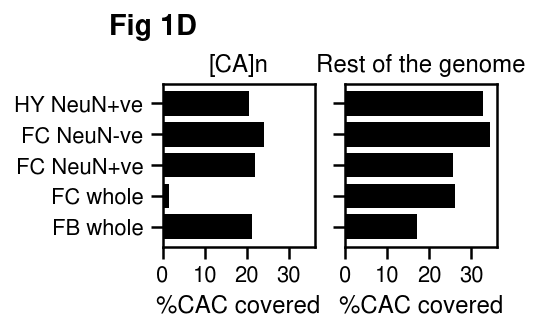

In [12]:
df = df.loc[["FB whole", "FC whole", "FC NeuN+ve", "FC NeuN-ve", "HY NeuN+ve"]]*100
fig, (ax, bx) = plt.subplots(1, 2, figsize=(3, 1.5), sharex=True, sharey=True)
bx.barh(df.index, df["CAC"].values, color="black")
ax.barh(df.index, df["CAn"].values, color="black")
ax.set_title("[CA]n")
bx.set_title("Rest of the genome")
ax.set_xlabel("%CAC covered")
ax.set_xticks([0, 10, 20, 30])
bx.set_xlabel("%CAC covered")
_ = ax.text(0.0, 1.2, "Fig 1D", transform=fig.transFigure, va='top', weight="bold", fontsize="x-large")
fig.savefig("pdfs/fig1d.pdf")

# Fig S1A

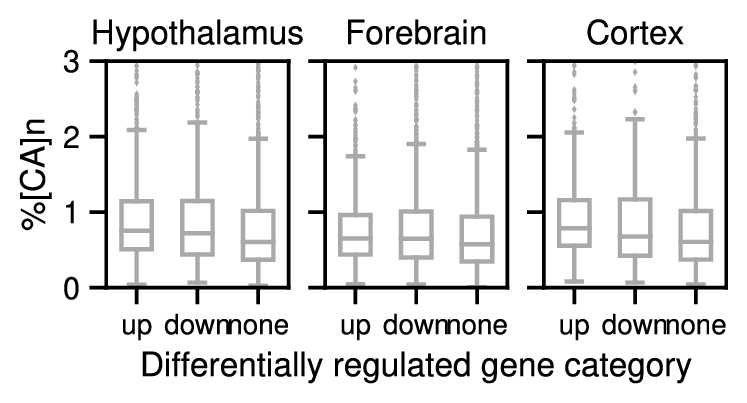

In [1]:
from wand.image import Image as WImage
WImage(filename="../rnaseq/plots/sfig1a.pdf", resolution=200)

# Fig S1B

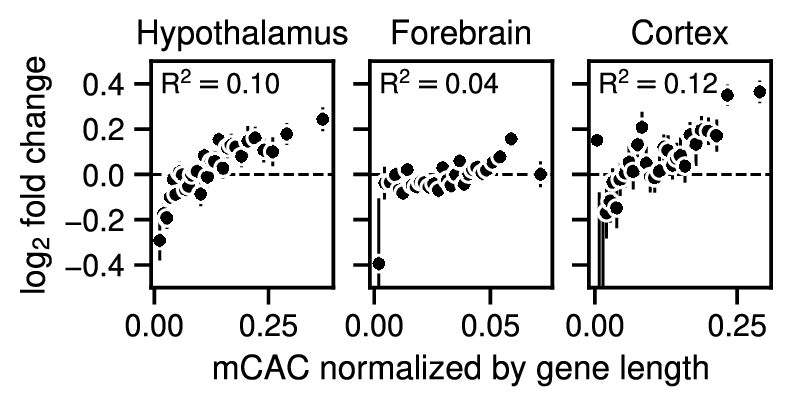

In [14]:
from wand.image import Image as WImage
WImage(filename="../rnaseq/plots/sfig1b.pdf", resolution=200)